# PROBLEM STATEMENT

We have to analyze the customer reviews for various products of an E-commerce company and create a report that
classifies the products based on the customer reviews.

# PROBLEM OBJECTIVE

1. Find various trends and patterns in the reviews data, create useful insights that
best describe the product quality.
2. Classify each review based on the sentiment associated with the same

# DATA DESCRIPTION

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews . Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [3]:
#importing the training data
df=pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#Summary of the dataset
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


# DATA PRE-PROCESSING

In this step we Removed html tags, remove URLs and special charecters and punctuations

In [5]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['Text']=df['Text'].apply(denoise_text)

**Leaving the features with text data aside, we now find the correlation between other different features in the datset and their influence on score**

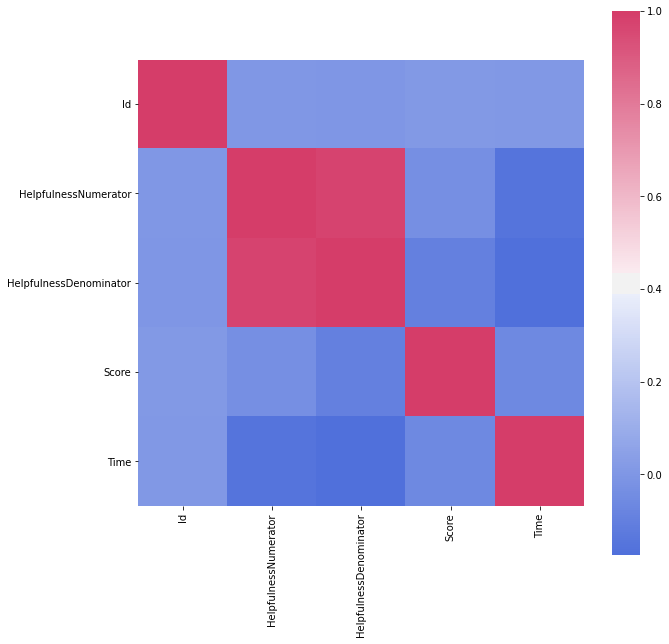

In [6]:
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [7]:
del df['Id']
del df['Time']
del df['UserId']
del df['ProductId']
del df['HelpfulnessNumerator']
del df['HelpfulnessDenominator']

In [8]:
df.head()

,ProfileName,Score,Summary,Text
0,delmartian,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,dll pa,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"Natalia Corres ""Natalia Corres""",4,"""Delight"" says it all",This is a confection that has been around a fe...
3,Karl,2,Cough Medicine,If you are looking for the secret ingredient i...
4,"Michael D. Bigham ""M. Wassir""",5,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
df['Text'] = df['Text'] + ' ' + df['Summary'] + ' ' + df['ProfileName']
del df['Summary']
del df['ProfileName']
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [10]:
def score_sentiment(score):
    # Replace scores of 1,2,3 with 0 (not good) and 4,5 with 1 (good)
    if(score == 1 or score == 2 or score == 3):
        return 0
    else:
        return 1
df.Score = df.Score.apply(score_sentiment)    

In [11]:
df.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


In [12]:
df.isna().sum()

Score     0
Text     43
dtype: int64

In [13]:
df.Text.fillna("",inplace = True)

In [14]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [15]:
stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)

In [16]:
df.Text = df.Text.apply(stem_text)

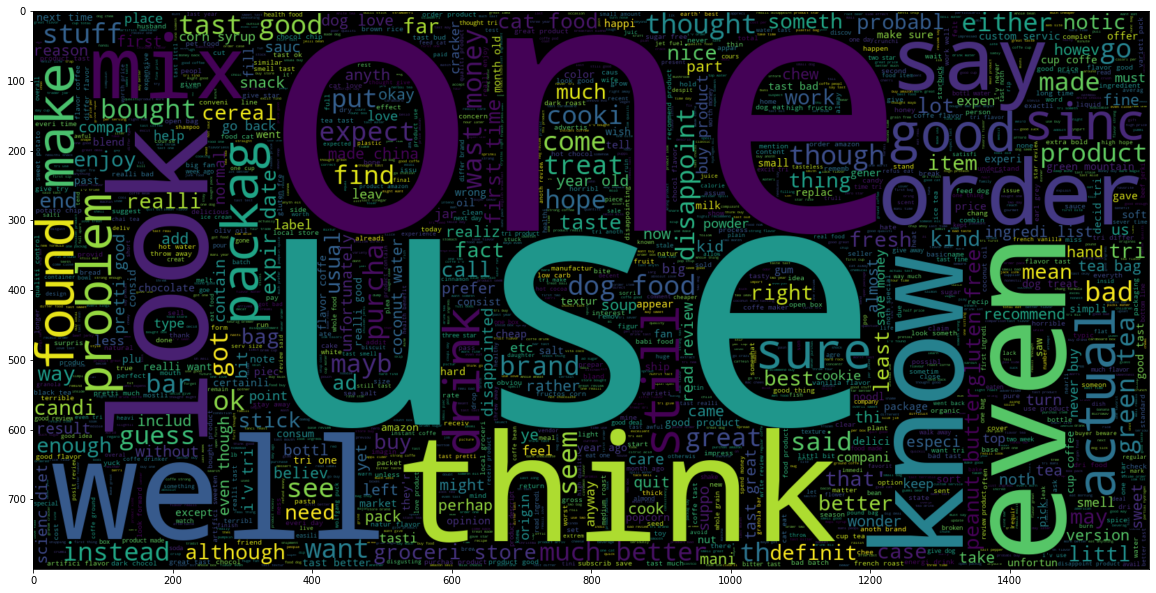

In [17]:
plt.figure(figsize = (20,20)) # Text with bad/average reviews
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800).generate(" ".join(df[df.Score == 0].Text))
plt.imshow(wc , interpolation = 'bilinear')

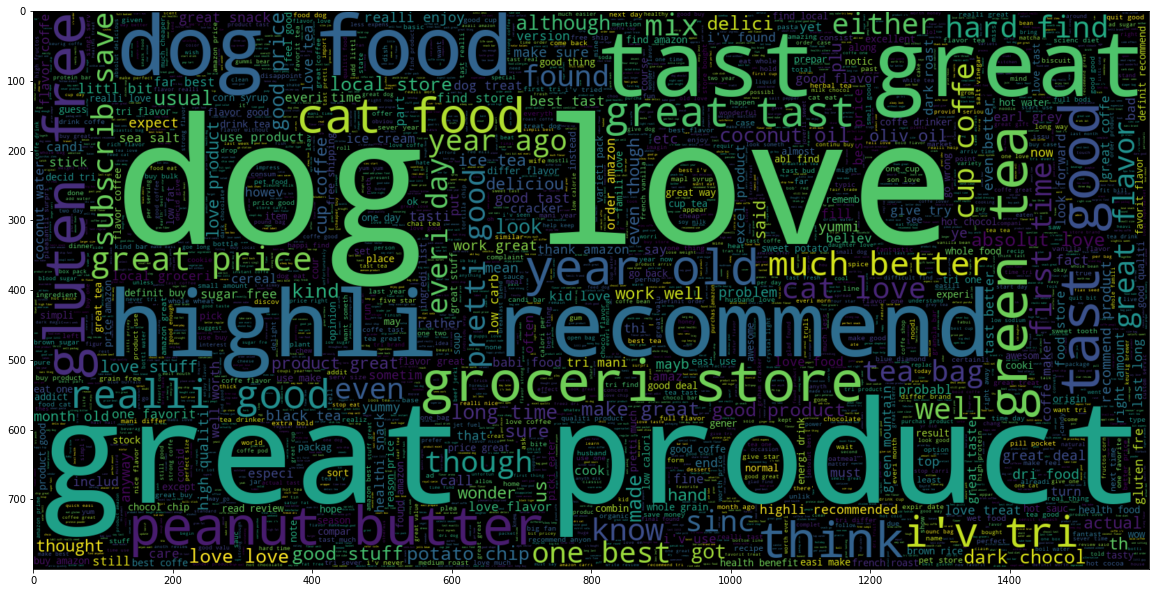

In [18]:
plt.figure(figsize = (20,20)) # Text with good reviews
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800).generate(" ".join(df[df.Score ==1].Text))
plt.imshow(wc , interpolation = 'bilinear')

# ALGORITHM USED

We will use the Linear regression.
Reason -- Since we have to classify each review based on the sentiments associated with it so we're using Linear reg as a classifiaction algorithm 

In [19]:
x_train,x_test,y_train,y_test = train_test_split(df.Text,df.Score,random_state = 0)

In [20]:
cv=CountVectorizer(min_df=0,max_df=1,ngram_range=(1,2))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (426340, 2485966)
BOW_cv_test: (142114, 2485966)


In [21]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [22]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)

In [23]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.8005052281970813


In [24]:
#Classification report for bag of words
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['0','1'])
print(lr_bow_report)

              precision    recall  f1-score   support

           0       0.98      0.09      0.17     31133
           1       0.80      1.00      0.89    110981

    accuracy                           0.80    142114
   macro avg       0.89      0.55      0.53    142114
weighted avg       0.84      0.80      0.73    142114



# INFERENCE

(1) As we can see from the classification report F1-score for "0" is 0.17 while for "1" is 0.89
(2) This implies that postive reviews are very frequent.
(3) Most of the produtcs are grabbing positive sentiments from the customers.

# FUTURE POSSIBILITIES

We can modify this classification on the basis of score feature.
For eg we can analyse the reviews with score "3" whether the sentiment score is inclined towards 0 or 1, i.e the review is negative or positive.